In [38]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import trange
from utils import *
%matplotlib inline

In [47]:
image_shape = (48, 48)
val_split = 0.25
batch_size = 16
max_steps = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [74]:
data_dir = 'generated/csawgan_gp/'
for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        print(f'{folder}: {len(os.listdir(os.path.join(data_dir, folder)))}')
classes = os.listdir(data_dir)

here_we_go: 680
kiss: 504
disgust: 712
cringe: 709
sad: 644
angry: 694
surprise: 692
clenched_teeth: 624
eye_roll: 647
very_sad: 670


In [5]:
train_tfms = tt.Compose([
    tt.Resize(image_shape), 
    tt.Grayscale(num_output_channels=1), 
    tt.ToTensor()
])

# all_data = ImageFolder(data_dir, transform=train_tfms)
# all_data = Subset(all_data, np.random.choice(len(all_data), 12000, replace=False))
# print(len(all_data))
# # train, val = torch.utils.data.random_split(all_data, [int((1-val_split)*len(all_data))+1, int(val_split*len(all_data))])
# train, val = torch.utils.data.random_split(all_data, [10000, 2000])
# train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=3, pin_memory=True)
# val_dl = DataLoader(val, batch_size, shuffle=True, num_workers=3, pin_memory=True)

## Using a GPU

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device = get_default_device()
device

device(type='cpu')

# Model

In [59]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        out = torch.nn.functional.softmax(out, dim=-1)
        return out

In [60]:
def load_ckpt(checkpoint_path, model): 
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
    return model

# Model inversion 
Code from Tim Gianitsos http://cs230.stanford.edu/projects_spring_2020/reports/38961673.pdf

In [79]:
ckpt_path = './model_ckpt/emotion_detection_original.pth'
show_freq = 100
num_step = 2000
print(device)

cpu


In [80]:
model = to_device(ResNet(1, 10), device)
model = load_ckpt(ckpt_path, model)

In [83]:
def model_invert(label, max_steps, learning_rate, net):
    torch.set_grad_enabled(True)
    net.eval()
    x = torch.autograd.Variable(torch.zeros(size=(1, 1, 48, 48), dtype=torch.float,requires_grad=True), requires_grad=True)
    x_min = x
    c_min = float('inf')
    print('Model inversion')
    for step in trange(max_steps):
        net.zero_grad()
        cost = 1 - net(x)[0, label]
        cost.backward()
        x = torch.autograd.Variable(x - learning_rate * x.grad, requires_grad=True)
        if c_min > cost:
            c_min = cost
            x_min = x
        if step % show_freq == 0: 
            print(cost)
    plt.imshow(x_min.detach().numpy()[0][0], plt.cm.gray)
    plt.show()

  0%|          | 1/2000 [00:00<04:46,  6.99it/s]

Model inversion
tensor(0.8921, grad_fn=<RsubBackward1>)


  5%|▌         | 103/2000 [00:09<03:03, 10.33it/s]

tensor(0.8139, grad_fn=<RsubBackward1>)


 10%|█         | 202/2000 [00:19<03:15,  9.21it/s]

tensor(0.7257, grad_fn=<RsubBackward1>)


 15%|█▌        | 303/2000 [00:29<02:41, 10.50it/s]

tensor(0.5906, grad_fn=<RsubBackward1>)


 20%|██        | 403/2000 [00:39<02:32, 10.49it/s]

tensor(0.4918, grad_fn=<RsubBackward1>)


 25%|██▌       | 501/2000 [00:49<02:21, 10.59it/s]

tensor(0.4125, grad_fn=<RsubBackward1>)


 30%|███       | 603/2000 [00:59<02:20,  9.94it/s]

tensor(0.3664, grad_fn=<RsubBackward1>)


 35%|███▌      | 703/2000 [01:08<02:03, 10.52it/s]

tensor(0.3357, grad_fn=<RsubBackward1>)


 40%|████      | 803/2000 [01:18<01:55, 10.38it/s]

tensor(0.3116, grad_fn=<RsubBackward1>)


 45%|████▌     | 903/2000 [01:27<01:43, 10.65it/s]

tensor(0.2919, grad_fn=<RsubBackward1>)


 50%|█████     | 1003/2000 [01:37<01:34, 10.51it/s]

tensor(0.2766, grad_fn=<RsubBackward1>)


 55%|█████▌    | 1103/2000 [01:46<01:24, 10.68it/s]

tensor(0.2636, grad_fn=<RsubBackward1>)


 60%|██████    | 1202/2000 [01:56<01:14, 10.65it/s]

tensor(0.2526, grad_fn=<RsubBackward1>)


 65%|██████▌   | 1301/2000 [02:05<01:08, 10.25it/s]

tensor(0.2416, grad_fn=<RsubBackward1>)


 70%|███████   | 1402/2000 [02:15<00:56, 10.63it/s]

tensor(0.2315, grad_fn=<RsubBackward1>)


 75%|███████▌  | 1502/2000 [02:24<00:46, 10.72it/s]

tensor(0.2232, grad_fn=<RsubBackward1>)


 80%|████████  | 1603/2000 [02:34<00:37, 10.54it/s]

tensor(0.2157, grad_fn=<RsubBackward1>)


 85%|████████▌ | 1702/2000 [02:43<00:28, 10.61it/s]

tensor(0.2092, grad_fn=<RsubBackward1>)


 90%|█████████ | 1802/2000 [02:53<00:18, 10.54it/s]

tensor(0.2033, grad_fn=<RsubBackward1>)


 95%|█████████▌| 1902/2000 [03:03<00:09, 10.60it/s]

tensor(0.1980, grad_fn=<RsubBackward1>)


100%|██████████| 2000/2000 [03:12<00:00, 10.39it/s]


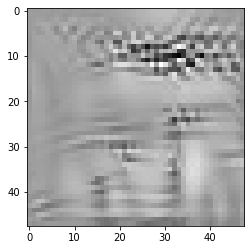

In [84]:
model_invert(0, num_step, 0.01, model)

  0%|          | 1/2000 [00:00<03:41,  9.04it/s]

Model inversion
tensor(0.8339, grad_fn=<RsubBackward1>)


  5%|▌         | 103/2000 [00:10<03:00, 10.53it/s]

tensor(0.0738, grad_fn=<RsubBackward1>)


 10%|█         | 202/2000 [00:20<04:15,  7.05it/s]

tensor(0.0462, grad_fn=<RsubBackward1>)


 15%|█▌        | 302/2000 [00:31<02:45, 10.24it/s]

tensor(0.0352, grad_fn=<RsubBackward1>)


 20%|██        | 403/2000 [00:40<02:30, 10.63it/s]

tensor(0.0291, grad_fn=<RsubBackward1>)


 25%|██▌       | 502/2000 [00:50<02:20, 10.66it/s]

tensor(0.0251, grad_fn=<RsubBackward1>)


 30%|███       | 602/2000 [01:00<02:29,  9.38it/s]

tensor(0.0224, grad_fn=<RsubBackward1>)


 35%|███▌      | 701/2000 [01:09<02:02, 10.63it/s]

tensor(0.0204, grad_fn=<RsubBackward1>)


 40%|████      | 803/2000 [01:19<02:12,  9.01it/s]

tensor(0.0189, grad_fn=<RsubBackward1>)


 45%|████▌     | 902/2000 [01:30<02:00,  9.09it/s]

tensor(0.0177, grad_fn=<RsubBackward1>)


 50%|█████     | 1002/2000 [01:40<01:40,  9.97it/s]

tensor(0.0166, grad_fn=<RsubBackward1>)


 55%|█████▌    | 1102/2000 [01:51<01:25, 10.46it/s]

tensor(0.0157, grad_fn=<RsubBackward1>)


 60%|██████    | 1202/2000 [02:01<01:27,  9.09it/s]

tensor(0.0149, grad_fn=<RsubBackward1>)


 65%|██████▌   | 1303/2000 [02:11<01:05, 10.60it/s]

tensor(0.0142, grad_fn=<RsubBackward1>)


 70%|███████   | 1403/2000 [02:21<00:57, 10.46it/s]

tensor(0.0136, grad_fn=<RsubBackward1>)


 75%|███████▌  | 1503/2000 [02:31<00:47, 10.45it/s]

tensor(0.0131, grad_fn=<RsubBackward1>)


 80%|████████  | 1602/2000 [02:41<00:38, 10.47it/s]

tensor(0.0126, grad_fn=<RsubBackward1>)


 85%|████████▌ | 1702/2000 [02:51<00:28, 10.32it/s]

tensor(0.0122, grad_fn=<RsubBackward1>)


 90%|█████████ | 1802/2000 [03:00<00:18, 10.47it/s]

tensor(0.0118, grad_fn=<RsubBackward1>)


 95%|█████████▌| 1902/2000 [03:10<00:09, 10.39it/s]

tensor(0.0114, grad_fn=<RsubBackward1>)


100%|██████████| 2000/2000 [03:19<00:00, 10.00it/s]


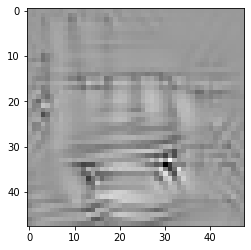

In [85]:
model_invert(1, num_step, 0.01, model)

  0%|          | 1/2000 [00:00<04:26,  7.49it/s]

Model inversion
tensor(0.9154, grad_fn=<RsubBackward1>)


  5%|▌         | 103/2000 [00:10<02:55, 10.80it/s]

tensor(0.8875, grad_fn=<RsubBackward1>)


 10%|█         | 202/2000 [00:20<02:53, 10.38it/s]

tensor(0.8614, grad_fn=<RsubBackward1>)


 15%|█▌        | 303/2000 [00:30<02:43, 10.40it/s]

tensor(0.8080, grad_fn=<RsubBackward1>)


 20%|██        | 402/2000 [00:39<02:46,  9.61it/s]

tensor(0.7266, grad_fn=<RsubBackward1>)


 25%|██▌       | 502/2000 [00:49<02:21, 10.62it/s]

tensor(0.6615, grad_fn=<RsubBackward1>)


 30%|███       | 602/2000 [00:58<02:14, 10.36it/s]

tensor(0.6137, grad_fn=<RsubBackward1>)


 35%|███▌      | 703/2000 [01:08<02:04, 10.43it/s]

tensor(0.5678, grad_fn=<RsubBackward1>)


 40%|████      | 803/2000 [01:19<01:55, 10.39it/s]

tensor(0.5235, grad_fn=<RsubBackward1>)


 45%|████▌     | 903/2000 [01:28<01:46, 10.25it/s]

tensor(0.4900, grad_fn=<RsubBackward1>)


 50%|█████     | 1002/2000 [01:38<01:38, 10.14it/s]

tensor(0.4620, grad_fn=<RsubBackward1>)


 55%|█████▌    | 1103/2000 [01:48<01:25, 10.47it/s]

tensor(0.4337, grad_fn=<RsubBackward1>)


 60%|██████    | 1202/2000 [01:58<01:29,  8.91it/s]

tensor(0.4129, grad_fn=<RsubBackward1>)


 65%|██████▌   | 1302/2000 [02:08<01:12,  9.69it/s]

tensor(0.3953, grad_fn=<RsubBackward1>)


 70%|███████   | 1403/2000 [02:19<00:57, 10.36it/s]

tensor(0.3802, grad_fn=<RsubBackward1>)


 75%|███████▌  | 1502/2000 [02:29<00:51,  9.60it/s]

tensor(0.3677, grad_fn=<RsubBackward1>)


 80%|████████  | 1603/2000 [02:39<00:38, 10.30it/s]

tensor(0.3566, grad_fn=<RsubBackward1>)


 85%|████████▌ | 1702/2000 [02:49<00:29, 10.25it/s]

tensor(0.3469, grad_fn=<RsubBackward1>)


 90%|█████████ | 1802/2000 [03:01<00:20,  9.80it/s]

tensor(0.3383, grad_fn=<RsubBackward1>)


 95%|█████████▌| 1903/2000 [03:11<00:09, 10.19it/s]

tensor(0.3305, grad_fn=<RsubBackward1>)


100%|██████████| 2000/2000 [03:21<00:00,  9.93it/s]


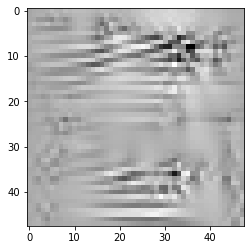

In [86]:
model_invert(2, num_step, 0.01, model)

  0%|          | 2/2000 [00:00<03:19, 10.01it/s]

Model inversion
tensor(0.9344, grad_fn=<RsubBackward1>)


  5%|▌         | 102/2000 [00:10<03:25,  9.22it/s]

tensor(0.0348, grad_fn=<RsubBackward1>)


 10%|█         | 203/2000 [00:20<02:49, 10.58it/s]

tensor(0.0222, grad_fn=<RsubBackward1>)


 15%|█▌        | 301/2000 [00:29<02:39, 10.65it/s]

tensor(0.0172, grad_fn=<RsubBackward1>)


 20%|██        | 402/2000 [00:39<03:02,  8.76it/s]

tensor(0.0144, grad_fn=<RsubBackward1>)


 25%|██▌       | 502/2000 [00:53<03:24,  7.33it/s]

tensor(0.0126, grad_fn=<RsubBackward1>)


 30%|███       | 602/2000 [01:05<02:49,  8.25it/s]

tensor(0.0112, grad_fn=<RsubBackward1>)


 35%|███▌      | 702/2000 [01:17<02:53,  7.48it/s]

tensor(0.0102, grad_fn=<RsubBackward1>)


 40%|████      | 802/2000 [01:29<02:11,  9.13it/s]

tensor(0.0094, grad_fn=<RsubBackward1>)


 45%|████▌     | 902/2000 [01:40<02:27,  7.47it/s]

tensor(0.0087, grad_fn=<RsubBackward1>)


 50%|█████     | 1002/2000 [01:50<01:36, 10.29it/s]

tensor(0.0082, grad_fn=<RsubBackward1>)


 55%|█████▌    | 1103/2000 [02:01<01:29,  9.99it/s]

tensor(0.0077, grad_fn=<RsubBackward1>)


 60%|██████    | 1202/2000 [02:11<01:29,  8.96it/s]

tensor(0.0073, grad_fn=<RsubBackward1>)


 65%|██████▌   | 1302/2000 [02:22<01:20,  8.64it/s]

tensor(0.0070, grad_fn=<RsubBackward1>)


 70%|███████   | 1403/2000 [02:32<00:58, 10.25it/s]

tensor(0.0067, grad_fn=<RsubBackward1>)


 75%|███████▌  | 1503/2000 [02:42<00:47, 10.35it/s]

tensor(0.0064, grad_fn=<RsubBackward1>)


 80%|████████  | 1603/2000 [02:51<00:36, 10.86it/s]

tensor(0.0061, grad_fn=<RsubBackward1>)


 85%|████████▌ | 1702/2000 [03:00<00:28, 10.58it/s]

tensor(0.0059, grad_fn=<RsubBackward1>)


 90%|█████████ | 1803/2000 [03:10<00:18, 10.58it/s]

tensor(0.0057, grad_fn=<RsubBackward1>)


 95%|█████████▌| 1903/2000 [03:20<00:09, 10.37it/s]

tensor(0.0055, grad_fn=<RsubBackward1>)


100%|██████████| 2000/2000 [03:29<00:00,  9.53it/s]


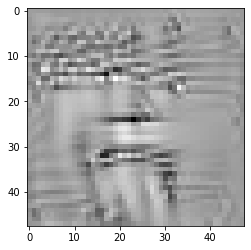

In [87]:
model_invert(3, num_step, 0.01, model)

  0%|          | 1/2000 [00:00<04:19,  7.70it/s]

Model inversion
tensor(0.8847, grad_fn=<RsubBackward1>)


  5%|▌         | 102/2000 [00:11<03:38,  8.70it/s]

tensor(0.2371, grad_fn=<RsubBackward1>)


 10%|█         | 202/2000 [00:22<03:22,  8.90it/s]

tensor(0.1566, grad_fn=<RsubBackward1>)


 15%|█▌        | 302/2000 [00:34<03:32,  7.98it/s]

tensor(0.1225, grad_fn=<RsubBackward1>)


 20%|██        | 402/2000 [00:47<03:05,  8.64it/s]

tensor(0.1028, grad_fn=<RsubBackward1>)


 25%|██▌       | 502/2000 [00:59<02:58,  8.40it/s]

tensor(0.0907, grad_fn=<RsubBackward1>)


 30%|███       | 602/2000 [01:11<03:02,  7.65it/s]

tensor(0.0820, grad_fn=<RsubBackward1>)


 35%|███▌      | 702/2000 [01:22<02:24,  9.01it/s]

tensor(0.0753, grad_fn=<RsubBackward1>)


 40%|████      | 802/2000 [01:34<02:21,  8.44it/s]

tensor(0.0702, grad_fn=<RsubBackward1>)


 45%|████▌     | 902/2000 [01:46<02:05,  8.75it/s]

tensor(0.0659, grad_fn=<RsubBackward1>)


 50%|█████     | 1002/2000 [01:58<02:00,  8.28it/s]

tensor(0.0624, grad_fn=<RsubBackward1>)


 55%|█████▌    | 1102/2000 [02:12<02:45,  5.42it/s]

tensor(0.0594, grad_fn=<RsubBackward1>)


 60%|██████    | 1202/2000 [02:25<01:29,  8.89it/s]

tensor(0.0568, grad_fn=<RsubBackward1>)


 65%|██████▌   | 1302/2000 [02:38<01:21,  8.57it/s]

tensor(0.0546, grad_fn=<RsubBackward1>)


 70%|███████   | 1402/2000 [02:51<01:38,  6.10it/s]

tensor(0.0526, grad_fn=<RsubBackward1>)


 75%|███████▌  | 1502/2000 [03:06<01:25,  5.82it/s]

tensor(0.0508, grad_fn=<RsubBackward1>)


 80%|████████  | 1602/2000 [03:22<01:04,  6.15it/s]

tensor(0.0492, grad_fn=<RsubBackward1>)


 85%|████████▌ | 1702/2000 [03:37<00:41,  7.18it/s]

tensor(0.0477, grad_fn=<RsubBackward1>)


 90%|█████████ | 1802/2000 [03:53<00:25,  7.62it/s]

tensor(0.0464, grad_fn=<RsubBackward1>)


 95%|█████████▌| 1902/2000 [04:08<00:15,  6.49it/s]

tensor(0.0452, grad_fn=<RsubBackward1>)


100%|██████████| 2000/2000 [04:21<00:00,  7.64it/s]


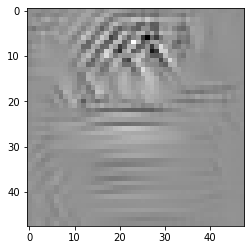

In [88]:
model_invert(4, num_steptep_step, 0.01, model)

  0%|          | 1/2000 [00:00<04:24,  7.56it/s]

Model inversion
tensor(0.8926, grad_fn=<RsubBackward1>)


  5%|▌         | 102/2000 [00:12<04:01,  7.87it/s]

tensor(0.6745, grad_fn=<RsubBackward1>)


 10%|█         | 202/2000 [00:25<04:25,  6.77it/s]

tensor(0.5516, grad_fn=<RsubBackward1>)


 15%|█▌        | 303/2000 [00:39<03:12,  8.79it/s]

tensor(0.4827, grad_fn=<RsubBackward1>)


 20%|██        | 401/2000 [00:50<02:36, 10.22it/s]

tensor(0.4380, grad_fn=<RsubBackward1>)


 25%|██▌       | 502/2000 [01:01<02:26, 10.22it/s]

tensor(0.4053, grad_fn=<RsubBackward1>)


 30%|███       | 603/2000 [01:11<02:10, 10.70it/s]

tensor(0.3806, grad_fn=<RsubBackward1>)


 35%|███▌      | 703/2000 [01:20<02:05, 10.37it/s]

tensor(0.3613, grad_fn=<RsubBackward1>)


 40%|████      | 803/2000 [01:29<01:51, 10.72it/s]

tensor(0.3458, grad_fn=<RsubBackward1>)


 45%|████▌     | 903/2000 [01:39<01:40, 10.86it/s]

tensor(0.3327, grad_fn=<RsubBackward1>)


 50%|█████     | 1003/2000 [01:48<01:32, 10.84it/s]

tensor(0.3215, grad_fn=<RsubBackward1>)


 55%|█████▌    | 1103/2000 [01:57<01:23, 10.70it/s]

tensor(0.3120, grad_fn=<RsubBackward1>)


 60%|██████    | 1203/2000 [02:07<01:13, 10.82it/s]

tensor(0.3031, grad_fn=<RsubBackward1>)


 65%|██████▌   | 1303/2000 [02:16<01:05, 10.58it/s]

tensor(0.2951, grad_fn=<RsubBackward1>)


 70%|███████   | 1402/2000 [02:26<00:53, 11.10it/s]

tensor(0.2874, grad_fn=<RsubBackward1>)


 75%|███████▌  | 1502/2000 [02:35<00:45, 11.02it/s]

tensor(0.2784, grad_fn=<RsubBackward1>)


 80%|████████  | 1602/2000 [02:44<00:36, 11.00it/s]

tensor(0.2709, grad_fn=<RsubBackward1>)


 85%|████████▌ | 1702/2000 [02:53<00:27, 10.81it/s]

tensor(0.2635, grad_fn=<RsubBackward1>)


 90%|█████████ | 1802/2000 [03:03<00:21,  9.02it/s]

tensor(0.2568, grad_fn=<RsubBackward1>)


 95%|█████████▌| 1902/2000 [03:13<00:09, 10.78it/s]

tensor(0.2505, grad_fn=<RsubBackward1>)


100%|██████████| 2000/2000 [03:23<00:00,  9.83it/s]


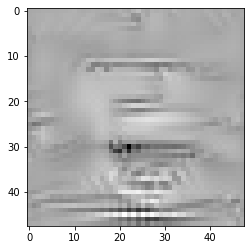

In [89]:
model_invert(5, num_step, 0.01, model)

  0%|          | 1/2000 [00:00<03:55,  8.47it/s]

Model inversion
tensor(0.8618, grad_fn=<RsubBackward1>)


  5%|▌         | 102/2000 [00:09<02:55, 10.82it/s]

tensor(0.0223, grad_fn=<RsubBackward1>)


 10%|█         | 202/2000 [00:18<02:44, 10.90it/s]

tensor(0.0141, grad_fn=<RsubBackward1>)


 15%|█▌        | 303/2000 [00:28<02:35, 10.89it/s]

tensor(0.0108, grad_fn=<RsubBackward1>)


 20%|██        | 403/2000 [00:37<02:26, 10.93it/s]

tensor(0.0090, grad_fn=<RsubBackward1>)


 25%|██▌       | 503/2000 [00:46<02:16, 11.00it/s]

tensor(0.0078, grad_fn=<RsubBackward1>)


 30%|███       | 602/2000 [00:55<02:08, 10.88it/s]

tensor(0.0069, grad_fn=<RsubBackward1>)


 35%|███▌      | 702/2000 [01:04<01:58, 10.91it/s]

tensor(0.0063, grad_fn=<RsubBackward1>)


 40%|████      | 802/2000 [01:14<01:49, 10.96it/s]

tensor(0.0058, grad_fn=<RsubBackward1>)


 45%|████▌     | 903/2000 [01:23<01:50,  9.97it/s]

tensor(0.0054, grad_fn=<RsubBackward1>)


 50%|█████     | 1003/2000 [01:32<01:31, 10.85it/s]

tensor(0.0051, grad_fn=<RsubBackward1>)


 55%|█████▌    | 1103/2000 [01:41<01:22, 10.91it/s]

tensor(0.0048, grad_fn=<RsubBackward1>)


 60%|██████    | 1203/2000 [01:51<01:16, 10.45it/s]

tensor(0.0045, grad_fn=<RsubBackward1>)


 65%|██████▌   | 1303/2000 [02:00<01:04, 10.77it/s]

tensor(0.0043, grad_fn=<RsubBackward1>)


 70%|███████   | 1402/2000 [02:13<01:15,  7.91it/s]

tensor(0.0041, grad_fn=<RsubBackward1>)


 75%|███████▌  | 1502/2000 [02:26<01:04,  7.69it/s]

tensor(0.0039, grad_fn=<RsubBackward1>)


 80%|████████  | 1602/2000 [02:41<00:59,  6.65it/s]

tensor(0.0038, grad_fn=<RsubBackward1>)


 85%|████████▌ | 1702/2000 [02:56<00:41,  7.13it/s]

tensor(0.0036, grad_fn=<RsubBackward1>)


 90%|█████████ | 1802/2000 [03:09<00:22,  8.81it/s]

tensor(0.0035, grad_fn=<RsubBackward1>)


 95%|█████████▌| 1902/2000 [03:22<00:12,  7.58it/s]

tensor(0.0034, grad_fn=<RsubBackward1>)


100%|██████████| 2000/2000 [03:34<00:00,  9.31it/s]


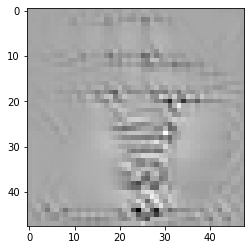

In [90]:
model_invert(6, num_step, 0.01, model)

  0%|          | 1/2000 [00:00<05:25,  6.14it/s]

Model inversion
tensor(0.9330, grad_fn=<RsubBackward1>)


  5%|▌         | 102/2000 [00:13<04:19,  7.31it/s]

tensor(0.8368, grad_fn=<RsubBackward1>)


 10%|█         | 202/2000 [00:27<04:10,  7.19it/s]

tensor(0.7797, grad_fn=<RsubBackward1>)


 15%|█▌        | 302/2000 [00:40<04:13,  6.69it/s]

tensor(0.7303, grad_fn=<RsubBackward1>)


 20%|██        | 402/2000 [00:56<04:15,  6.26it/s]

tensor(0.6857, grad_fn=<RsubBackward1>)


 25%|██▌       | 502/2000 [01:11<03:28,  7.19it/s]

tensor(0.6478, grad_fn=<RsubBackward1>)


 30%|███       | 602/2000 [01:27<04:12,  5.53it/s]

tensor(0.6164, grad_fn=<RsubBackward1>)


 35%|███▌      | 702/2000 [01:44<03:42,  5.82it/s]

tensor(0.5916, grad_fn=<RsubBackward1>)


 40%|████      | 802/2000 [02:01<03:28,  5.74it/s]

tensor(0.5693, grad_fn=<RsubBackward1>)


 45%|████▌     | 902/2000 [02:17<03:04,  5.94it/s]

tensor(0.5500, grad_fn=<RsubBackward1>)


 50%|█████     | 1002/2000 [02:34<02:33,  6.51it/s]

tensor(0.5332, grad_fn=<RsubBackward1>)


 55%|█████▌    | 1102/2000 [02:51<02:33,  5.85it/s]

tensor(0.5197, grad_fn=<RsubBackward1>)


 60%|██████    | 1202/2000 [03:08<02:26,  5.46it/s]

tensor(0.5078, grad_fn=<RsubBackward1>)


 65%|██████▌   | 1302/2000 [03:25<02:01,  5.77it/s]

tensor(0.4971, grad_fn=<RsubBackward1>)


 70%|███████   | 1402/2000 [03:41<01:43,  5.80it/s]

tensor(0.4871, grad_fn=<RsubBackward1>)


 75%|███████▌  | 1502/2000 [03:59<01:27,  5.70it/s]

tensor(0.4780, grad_fn=<RsubBackward1>)


 80%|████████  | 1602/2000 [04:15<01:08,  5.78it/s]

tensor(0.4694, grad_fn=<RsubBackward1>)


 85%|████████▌ | 1702/2000 [04:32<00:50,  5.91it/s]

tensor(0.4611, grad_fn=<RsubBackward1>)


 90%|█████████ | 1802/2000 [04:49<00:33,  5.83it/s]

tensor(0.4536, grad_fn=<RsubBackward1>)


 95%|█████████▌| 1902/2000 [05:05<00:16,  5.98it/s]

tensor(0.4467, grad_fn=<RsubBackward1>)


100%|██████████| 2000/2000 [05:22<00:00,  6.20it/s]


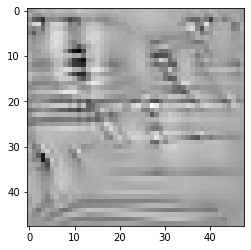

In [91]:
model_invert(7, num_step, 0.01, model)

  0%|          | 1/2000 [00:00<06:07,  5.44it/s]

Model inversion
tensor(0.9253, grad_fn=<RsubBackward1>)


  5%|▌         | 102/2000 [00:17<04:58,  6.35it/s]

tensor(0.5547, grad_fn=<RsubBackward1>)


 10%|█         | 202/2000 [00:34<05:33,  5.40it/s]

tensor(0.3123, grad_fn=<RsubBackward1>)


 15%|█▌        | 302/2000 [00:54<05:40,  4.99it/s]

tensor(0.2483, grad_fn=<RsubBackward1>)


 20%|██        | 402/2000 [01:09<03:59,  6.67it/s]

tensor(0.2152, grad_fn=<RsubBackward1>)


 25%|██▌       | 502/2000 [01:25<03:45,  6.65it/s]

tensor(0.1938, grad_fn=<RsubBackward1>)


 30%|███       | 602/2000 [01:40<03:40,  6.35it/s]

tensor(0.1788, grad_fn=<RsubBackward1>)


 35%|███▌      | 702/2000 [01:56<03:29,  6.21it/s]

tensor(0.1674, grad_fn=<RsubBackward1>)


 40%|████      | 801/2000 [02:14<03:49,  5.22it/s]

tensor(0.1583, grad_fn=<RsubBackward1>)


 45%|████▌     | 902/2000 [02:29<02:22,  7.68it/s]

tensor(0.1509, grad_fn=<RsubBackward1>)


 50%|█████     | 1002/2000 [02:43<02:16,  7.30it/s]

tensor(0.1445, grad_fn=<RsubBackward1>)


 55%|█████▌    | 1102/2000 [02:57<01:51,  8.08it/s]

tensor(0.1390, grad_fn=<RsubBackward1>)


 60%|██████    | 1202/2000 [03:13<02:02,  6.53it/s]

tensor(0.1342, grad_fn=<RsubBackward1>)


 65%|██████▌   | 1302/2000 [03:31<02:03,  5.66it/s]

tensor(0.1301, grad_fn=<RsubBackward1>)


 70%|███████   | 1401/2000 [03:50<02:07,  4.69it/s]

tensor(0.1264, grad_fn=<RsubBackward1>)


 75%|███████▌  | 1502/2000 [04:10<01:40,  4.98it/s]

tensor(0.1230, grad_fn=<RsubBackward1>)


 80%|████████  | 1602/2000 [04:32<01:24,  4.71it/s]

tensor(0.1199, grad_fn=<RsubBackward1>)


 85%|████████▌ | 1702/2000 [04:51<00:56,  5.24it/s]

tensor(0.1170, grad_fn=<RsubBackward1>)


 90%|█████████ | 1802/2000 [05:09<00:25,  7.62it/s]

tensor(0.1144, grad_fn=<RsubBackward1>)


 95%|█████████▌| 1902/2000 [05:23<00:14,  6.74it/s]

tensor(0.1120, grad_fn=<RsubBackward1>)


100%|██████████| 2000/2000 [05:38<00:00,  5.91it/s]


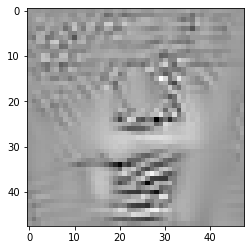

In [92]:
model_invert(8, num_step, 0.01, model)

  0%|          | 1/2000 [00:00<05:54,  5.63it/s]

Model inversion
tensor(0.9268, grad_fn=<RsubBackward1>)


  5%|▌         | 102/2000 [00:16<04:58,  6.37it/s]

tensor(0.5217, grad_fn=<RsubBackward1>)


 10%|█         | 202/2000 [00:31<04:32,  6.61it/s]

tensor(0.3732, grad_fn=<RsubBackward1>)


 15%|█▌        | 302/2000 [00:46<03:34,  7.92it/s]

tensor(0.3136, grad_fn=<RsubBackward1>)


 20%|██        | 402/2000 [01:01<03:47,  7.03it/s]

tensor(0.2784, grad_fn=<RsubBackward1>)


 25%|██▌       | 502/2000 [01:15<03:45,  6.65it/s]

tensor(0.2541, grad_fn=<RsubBackward1>)


 30%|███       | 602/2000 [01:30<03:27,  6.72it/s]

tensor(0.2340, grad_fn=<RsubBackward1>)


 35%|███▌      | 702/2000 [01:44<02:48,  7.68it/s]

tensor(0.2177, grad_fn=<RsubBackward1>)


 40%|████      | 802/2000 [01:59<03:06,  6.43it/s]

tensor(0.2051, grad_fn=<RsubBackward1>)


 45%|████▌     | 902/2000 [02:14<02:36,  7.03it/s]

tensor(0.1942, grad_fn=<RsubBackward1>)


 50%|█████     | 1002/2000 [02:29<02:47,  5.94it/s]

tensor(0.1853, grad_fn=<RsubBackward1>)


 55%|█████▌    | 1102/2000 [02:45<02:18,  6.47it/s]

tensor(0.1774, grad_fn=<RsubBackward1>)


 60%|██████    | 1202/2000 [02:59<01:56,  6.83it/s]

tensor(0.1708, grad_fn=<RsubBackward1>)


 65%|██████▌   | 1302/2000 [03:14<01:39,  7.02it/s]

tensor(0.1651, grad_fn=<RsubBackward1>)


 70%|███████   | 1402/2000 [03:29<01:32,  6.44it/s]

tensor(0.1603, grad_fn=<RsubBackward1>)


 75%|███████▌  | 1502/2000 [03:43<01:06,  7.49it/s]

tensor(0.1559, grad_fn=<RsubBackward1>)


 80%|████████  | 1602/2000 [03:57<01:02,  6.39it/s]

tensor(0.1516, grad_fn=<RsubBackward1>)


 85%|████████▌ | 1702/2000 [04:12<00:46,  6.45it/s]

tensor(0.1477, grad_fn=<RsubBackward1>)


 90%|█████████ | 1802/2000 [04:26<00:29,  6.66it/s]

tensor(0.1443, grad_fn=<RsubBackward1>)


 95%|█████████▌| 1902/2000 [04:40<00:15,  6.52it/s]

tensor(0.1413, grad_fn=<RsubBackward1>)


100%|██████████| 2000/2000 [04:55<00:00,  6.78it/s]


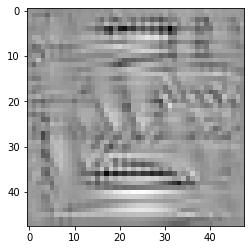

In [93]:
model_invert(9, num_step, 0.01, model)